In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *

Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "continous_3vars_reproduce_R_tramdag_std_100K_samps"   ## <--- set experiment name
seed=42
DATA_PATH = "/home/bule/TramDag/data"
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
os.makedirs(EXPERIMENT_DIR,exist_ok=True)

# 2.  Data

- same experiment as in the R CODE 
- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df



Loaded data from /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_std_100K_samps/continous_3vars_reproduce_R_tramdag_std_100K_samps.csv


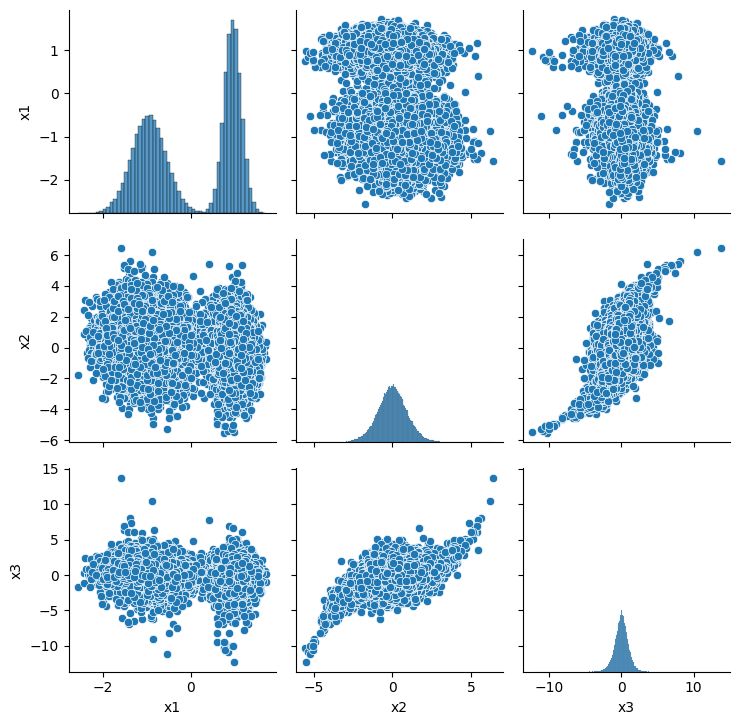

In [3]:

SEED = -1  # Set > 0 to enable reproducibility
F32 = 2    # Choose 1–5 to define the function
M32 = 'cs' # 'ls' or 'cs'

# ----- FUNCTION SELECTION -----
if F32 == 1:
    FUN_NAME = 'DPGLinear'
    f = lambda x: -0.3 * x
elif F32 == 2:
    FUN_NAME = 'DPG2x3+x'
    f = lambda x: 2 * x**3 + x
elif F32 == 3:
    FUN_NAME = 'DPG0.5exp'
    f = lambda x: 0.5 * np.exp(x)
elif F32 == 4:
    FUN_NAME = 'DPGatan'
    f = lambda x: 0.75 * np.arctan(5 * (x + 0.12))
elif F32 == 5:
    FUN_NAME = 'DPGSin'
    f = lambda x: 2 * np.sin(3 * x) + x
else:
    raise ValueError("Unknown Function F32")


# ----- DGP FUNCTION -----
def dgp(n_obs, doX=[None, None, None], seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")

    # X1 ~ GMM
    if doX[0] is None:
        X_1_A = np.random.normal(0.25, 0.1, n_obs)
        X_1_B = np.random.normal(0.73, 0.05, n_obs)
        choice = np.random.choice([0, 1], size=n_obs)
        X_1 = np.where(choice == 0, X_1_A, X_1_B)
    else:
        X_1 = np.full(n_obs, doX[0])

    # X2 from logistic inverse (qlogis)
    if doX[1] is None:
        U2 = np.random.uniform(0, 1, n_obs)
        x_2_dash = np.log(U2 / (1 - U2))
        X_2 = (x_2_dash - 2 * X_1) / 5.0
    else:
        X_2 = np.full(n_obs, doX[1])

    # X3 from inverse conditional transformation
    if doX[2] is None:
        U3 = np.random.uniform(0, 1, n_obs)
        x_3_dash = np.log(U3 / (1 - U3))
        X_3 = (x_3_dash + 0.2 * X_1 + f(X_2)) / 0.63
    else:
        X_3 = np.full(n_obs, doX[2])

    df = pd.DataFrame({'x1': X_1, 'x2': X_2, 'x3': X_3})    
    return df





# ----- RUN DGP -----
EXP_DATA_PATH=os.path.join(EXPERIMENT_DIR, f"{experiment_name}.csv")


if not os.path.exists(EXP_DATA_PATH):
    df = dgp(100_000, seed=SEED if SEED > 0 else -1)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)

else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")
    


### Standardize
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Get min_vals and max_vals as torch tensors
quantiles = df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05].values.astype(np.float32)
max_vals = quantiles.loc[0.95].values.astype(np.float32)

sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

### train test split

In [4]:
# train
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# Validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 80000, Validation size: 10000, Test size: 10000


# 4. Define graph Structure

- define graph and which shift and intercept terms to use


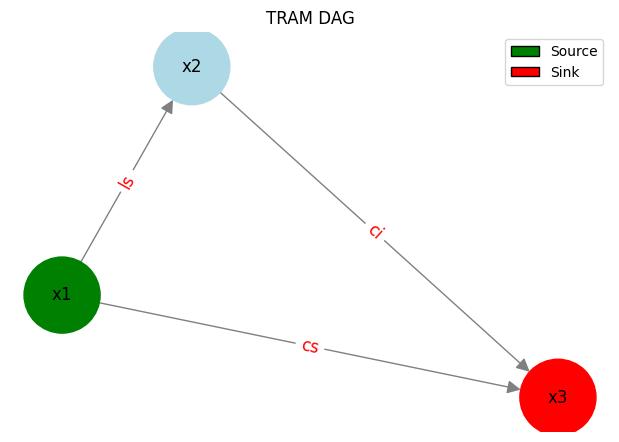

In [5]:
# describe if data is continous or  ordinal  ['cont', 'ord','other']
# note that other data than tabular can only be used as source 

# TODO support for interactions in CI model eg CI_1

# Example 1 dgp tramdag paper  3x3: 
data_type={'x1':'cont','x2':'cont','x3':'cont'}  # continous , images , ordinal
adj_matrix = np.array([
    [ "0", "ls", "cs"],  # A -> B (cs), A -> C (ls)
    [ "0", "0", "ci"],  # B -> D (ls)
    [ "0", "0", "0"],  # C -> D (cs)
], object)


# its also possible to have ci11 and ci12 etc to inlcude multiple varibales for a network for the intercept. aswell as for cs name it with ci11 ci12

plot_seed=5
plot_dag(adj_matrix,data_type, seed=plot_seed)

# 5. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

************* 
 Model has Complex intercepts and Coomplex shifts , please add your Model to the modelzoo 
************


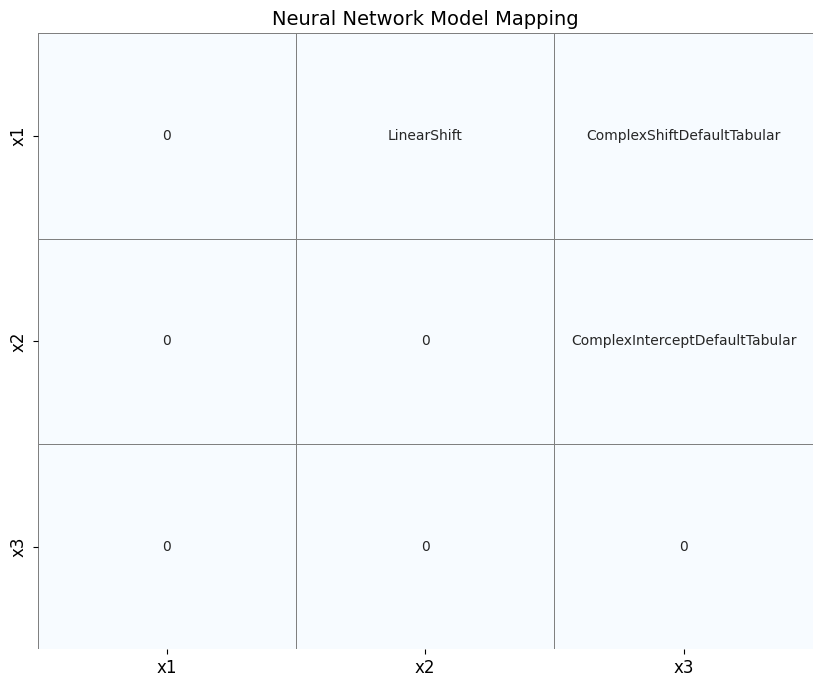

In [6]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix,data_type)

- add custom models for the ci or cs

In [7]:
# TODO: fucniton to automate
# if different models should be used, defin model in utils.models 
# e.g ComplexInterceptCUSTOMImage # any possible eg VITS

# rename the modelnames in the nn_names_matrix
# e.g.nn_names_matrix[2,3]='ComplexInterceptCUSTOMImage'  

- model configurations

In [8]:
#TODO : OPTION write config to a argparser to  and args object to pass datatypes

conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
# write min max to conf dict
for i,node in enumerate(data_type.keys()):
    conf_dict[node]['min']=min_vals[i].tolist()
    conf_dict[node]['max']=max_vals[i].tolist()
    

# write to file
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"{experiment_name}_conf.json")
with open(CONF_DICT_PATH, 'w') as f:
    json.dump(conf_dict, f, indent=4)
    
print(f"Configuration saved to {CONF_DICT_PATH}")

conf_dict

Configuration saved to /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_std_100K_samps/continous_3vars_reproduce_R_tramdag_std_100K_samps_conf.json


{'x1': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': -1.4532489776611328,
  'max': 1.2030662298202515},
 'x2': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'internal',
  'parents': ['x1'],
  'parents_datatype': {'x1': 'cont'},
  'transformation_terms_in_h()': {'x1': 'ls'},
  'transformation_term_nn_models_in_h()': {'x1': 'LinearShift'},
  'min': -1.6270862817764282,
  'max': 1.629428744316101},
 'x3': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'sink',
  'parents': ['x1', 'x2'],
  'parents_datatype': {'x1': 'cont', 'x2': 'cont'},
  'transformation_terms_in_h()': {'x1': 'cs', 'x2': 'ci'},
  'transformation_term_nn_models_in_h()': {'x1': 'ComplexShiftDefaultTabular',
   'x2': 'ComplexInterceptDefaultTabular'},
  'min': -1.6275806427001953,
  'max': 1.5561425685882568}}

## 6. Fit models

- each model independently fitting

In [9]:
DEV_TRAINING=True
train_list=['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required

batch_size = 512 
epochs = 400   # <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
use_scheduler = True

In [ ]:
# For each NODE 
for node in conf_dict:
    # Skip if node is not in train_list
    if node not in train_list:
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')

    # Skip unsupported types
    if (conf_dict[node]['node_type'] == 'source') and (conf_dict[node]['node_type'] == 'other'):
        continue

    ########################## 1. Create Model ##############################
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=True)
    tram_model = tram_model.to(device)

    ########################## 2. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=32, verbose=True)

    ########################## 3. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)

    model_path = os.path.join(NODE_DIR, "best_model.pt")
    last_model_path = os.path.join(NODE_DIR, "last_model.pt")
    train_hist_path = os.path.join(NODE_DIR, "train_loss_hist.json")
    val_hist_path = os.path.join(NODE_DIR, "val_loss_hist.json")

    ########################## 4. Load Model & History ######################
    if os.path.exists(model_path) and os.path.exists(train_hist_path) and os.path.exists(val_hist_path):
        print("Existing model found. Loading weights and history...")
        tram_model.load_state_dict(torch.load(model_path))

        with open(train_hist_path, 'r') as f:
            train_loss_hist = json.load(f)
        with open(val_hist_path, 'r') as f:
            val_loss_hist = json.load(f)

        start_epoch = len(train_loss_hist)
        best_val_loss = min(val_loss_hist)
        print(f"Continuing training from epoch {start_epoch}...")
    else:
        print("No existing model found. Starting fresh...")
        train_loss_hist = []
        val_loss_hist = []
        start_epoch = 0
        best_val_loss = float('inf')

    # Skip if already trained
    if start_epoch >= epochs:
        print(f"Node {node} already trained for {epochs} epochs. Skipping.")
        continue

    ########################## 5. Optimizer & Scheduler ######################
    optimizer = torch.optim.AdamW(tram_model.parameters(), lr=0.01, eps=1e-8, weight_decay=1e-2)

    if use_scheduler:
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

        

    ########################## 6. Min/Max Tensor #############################
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    ########################## 7. Training Loop ##############################

    if DEV_TRAINING:
        for epoch in range(start_epoch, epochs):
            epoch_start = time.time()

            #####  Training #####
            train_start = time.time()
            train_loss = 0.0
            tram_model.train()
            for x, y in train_loader:
                optimizer.zero_grad()
                y = y.to(device)

                int_input, shift_list = preprocess_inputs(x, device=device)
                y_pred = tram_model(int_input=int_input, shift_input=shift_list)

                loss = contram_nll(y_pred, y, min_max=min_max)
                loss.backward()
                optimizer.step()

                if use_scheduler:
                    scheduler.step()

                train_loss += loss.item()
            train_time = time.time() - train_start

            avg_train_loss = train_loss / len(train_loader)
            train_loss_hist.append(avg_train_loss)

            ##### Validation #####
            val_start = time.time()
            val_loss = 0.0
            tram_model.eval()
            with torch.no_grad():
                for x, y in val_loader:
                    y = y.to(device)
                    int_input, shift_list = preprocess_inputs(x, device=device)
                    y_pred = tram_model(int_input=int_input, shift_input=shift_list)
                    loss = contram_nll(y_pred, y, min_max=min_max)
                    val_loss += loss.item()
            val_time = time.time() - val_start

            avg_val_loss = val_loss / len(val_loader)
            val_loss_hist.append(avg_val_loss)

            ##### Saving #####
            save_start = time.time()
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(tram_model.state_dict(), model_path)
                print("Saved new best model.")

            torch.save(tram_model.state_dict(), last_model_path)

            with open(train_hist_path, 'w') as f:
                json.dump(train_loss_hist, f)
            with open(val_hist_path, 'w') as f:
                json.dump(val_loss_hist, f)
            save_time = time.time() - save_start

            epoch_total = time.time() - epoch_start

            ##### Epoch Summary #####
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
            print(f"  [Train: {train_time:.2f}s | Val: {val_time:.2f}s | Save: {save_time:.2f}s | Total: {epoch_total:.2f}s]")




----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
No existing model found. Starting fresh...


(out['min'][0],out['max'][1])

- NLL curves

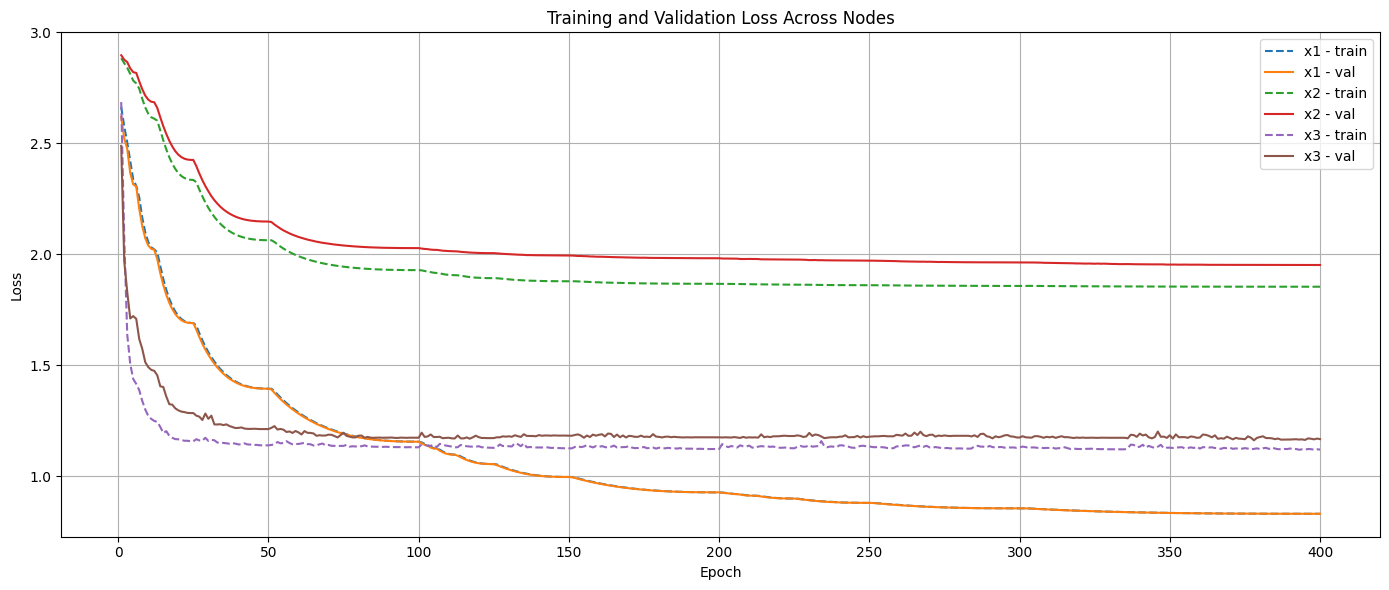

In [ ]:
plt.figure(figsize=(14, 6))
for node in conf_dict:
    train_hist, val_hist = load_history(node, EXPERIMENT_DIR)
    if train_hist is None or val_hist is None:
        print(f"No history found for node: {node}")
        continue

    epochs = range(1, len(train_hist) + 1)
    plt.plot(epochs, train_hist, label=f"{node} - train", linestyle="--")
    plt.plot(epochs, val_hist, label=f"{node} - val")

plt.title("Training and Validation Loss Across Nodes")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Sample from Graph

In [ ]:
n = 100_000  # Desired number of latent samples 
batch_size = 1
verbose=True
delete_all_previously_sampled=True

if delete_all_previously_sampled:
    delete_all_samplings(conf_dict,EXPERIMENT_DIR)

Deleted directory: /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_std_100K_samps/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_std_100K_samps/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_std_100K_samps/x3/sampling


In [ ]:
for node in conf_dict:
    print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--')
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    SAMPLING_DIR=os.path.join(NODE_DIR, 'sampling')
    os.makedirs(SAMPLING_DIR,exist_ok=True)
    
    #checkk if parents are sampled already
    if check_roots_and_latents(NODE_DIR,verbose=verbose):
        continue
    
    skipping_node =False
    # check if node is source or not
    if conf_dict[node]['node_type'] == 'source':
        pass
    else:
        for parent in conf_dict[node]['parents']:
            if not check_roots_and_latents(os.path.join(EXPERIMENT_DIR, parent),verbose=verbose):
                skipping_node=True
                break
            
    if skipping_node:
        print(f"Skipping {node} as parent {parent} is not sampled yet.")
        continue
            
    
    #sampling from latent
    latent_sample = sample_standard_logistic((n,), device=device)
    if verbose:
        print("-- sampled latents")
    
    
    # load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose)
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path))
    if verbose:
        print("-- loaded modelweights")
    
    #Sampling Dataloader
    dataset = SamplingDataset(node=node,EXPERIMENT_DIR=EXPERIMENT_DIR,number_of_samples=n, conf_dict=conf_dict, transform=None)
    sample_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
    
    
    #Forward pass with the sampled data
    output_list = []
    with torch.no_grad():
        for x in tqdm(sample_loader, desc=f"Sampling {node}"):
            x = [xi.to(device) for xi in x]
            int_input, shift_list = preprocess_inputs(x, device=device)
            model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
            output_list.append(model_outputs)

    if conf_dict[node]['node_type'] == 'source':
        
        if verbose:
            print("source node, Defaults to SI and 1 as inputs")
            
        theta_single =     output_list[0]['int_out'][0]  # Shape: (20,)
        theta_single=transform_intercepts_continous(theta_single)
        thetas_expanded = theta_single.repeat(n, 1)  # Shape: (n, 20)
        shifts = torch.zeros(n, device=device)
        
    else:
        
        if verbose:
            print("node has parents, previously sampled data is loaded for each pa(node)")
            
        y_pred=merge_outputs(output_list, skip_nan=True)
        shifts=y_pred['shift_out']
        if shifts is None:
            print("shift_out was None; defaulting to zeros.")
            shifts = torch.zeros(n, device=device)
        thetas=y_pred['int_out']
        thetas_expanded=transform_intercepts_continous(thetas).squeeze()
        shifts=shifts.squeeze()
        print(thetas_expanded.shape)
        print(shifts.shape)
        
        

    low = torch.full((n,), -1e5, device=device)
    high = torch.full((n,), 1e5, device=device)
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)
    

    ## Root finder
    root = bisection_root_finder(
    lambda targets: vectorized_object_function(
        thetas_expanded,
        targets,
        shifts,
        latent_sample,
        k_min=min_max[0],
        k_max=min_max[1]
    ),low,high, max_iter=10_000,tol=1e-10)
    
    #### Saving
    # save root and latents to 
    root_path = os.path.join(SAMPLING_DIR,"roots.pt")
    latents_path=os.path.join(SAMPLING_DIR, "latents.pt")
    
    if torch.isnan(root).any():
        print(f'caution! sampling for {node} consits of nans')
    
    torch.save(root, root_path)
    torch.save(latent_sample, latents_path)


----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/continous_3vars_reproduce_R_tramdag_std_100K_samps/x1/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


Sampling x1: 100%|██████████| 100000/100000 [00:18<00:00, 5337.24it/s]


source node, Defaults to SI and 1 as inputs


Bisection root finding:   2%|▏         | 153/10000 [00:01<01:16, 128.46it/s]


KeyboardInterrupt: 

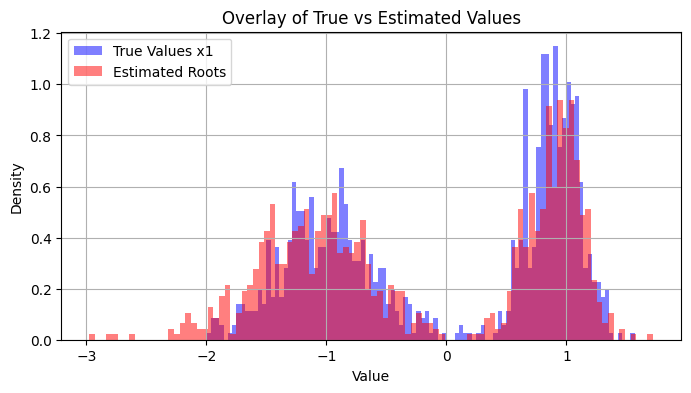

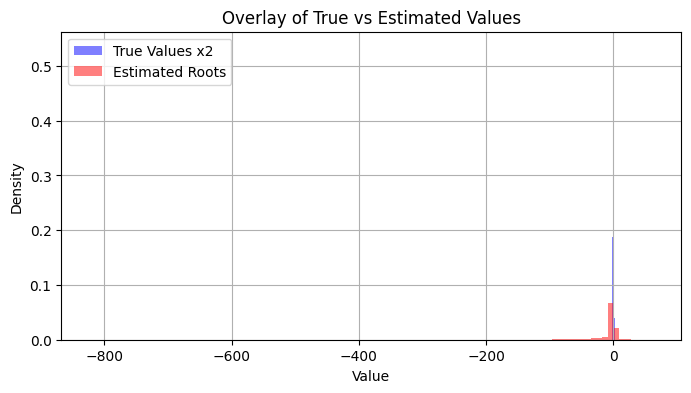

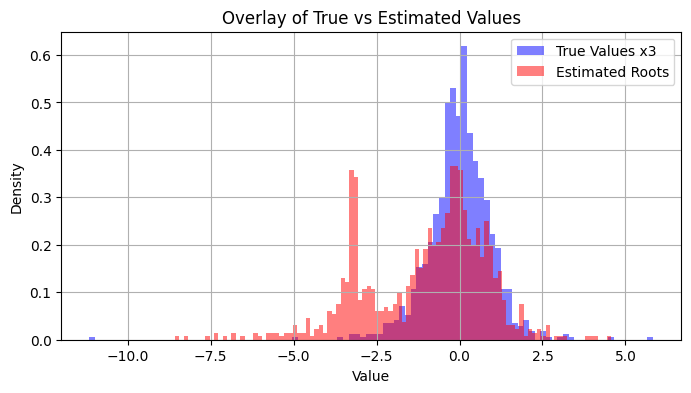

In [ ]:
## BUG in the sampling part 
for node in conf_dict.keys():
    root_np = torch.load(f'/home/bule/TramDag/dev_experiment_logs/{experiment_name}/{node}/sampling/roots.pt').cpu()
    # Plot overlaid histograms
    plt.figure(figsize=(8, 4))
    plt.hist(df[node] , bins=100, alpha=0.5, label=f'True Values {node}', color='blue', density=True)
    plt.hist(root_np, bins=100, alpha=0.5, label='Estimated Roots', color='red', density=True)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title("Overlay of True vs Estimated Values")
    plt.legend()
    plt.grid(True)
    plt.show()